<a href="https://colab.research.google.com/github/JeremyKrick/traffic-trend-predictor/blob/main/Final_Project_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project
####Building IOT application for Smart City to enhance urban mobility by harnessing the power of IoT to make cities smarter and more livable. The system will utilize ML to classify traffic conditions and LSTMs for forecasting pickup trends.

## Models
#### Model 1: Machine Learning – Classify the traffic conditions (e.g., light, moderate, heavy) in different zones of NYC using ML.
#### Model 2: Time Series Prediction – Forecast the future demand for Uber pickups across NYC using LSTM.

## Dataset
#### Dataset- Source of the dataset is NYC Taxi & Limousine Commission (TLC) - https://github.com/fivethirtyeight/uber-tlc-foil-response. It was obtained by FiveThirtyEight through a Freedom of Information Law request on July 20, 2015.


In [57]:
#import required libraries
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from collections import Counter
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation
from keras.utils import pad_sequences
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC   # The SVM Classifier from Scikit
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import time

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

## Load the Uber Data for the month of Jan-June 2015

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path_uber_15='/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15.csv'

Mounted at /content/drive


The dataset cosist for following columns -
1. Dispatching_base_num- The TLC base company code of the base that dispatched the Uber
2. Pickup_date- The date and time of the Uber pickup
3. Affiliated_base_num- The TLC base company code affiliated with the Uber pickup
4. locationID- The pickup location ID affiliated with the Uber pickup

In [3]:
df_uber = pd.read_csv(path_uber_15, delimiter = ",")
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


## Data Pre-processing

In [4]:
df_uber['Pickup_date']= pd.to_datetime(df_uber['Pickup_date'])

In [5]:
df_uber.dtypes

Dispatching_base_num            object
Pickup_date             datetime64[ns]
Affiliated_base_num             object
locationID                       int64
dtype: object

In [6]:
#convert datetime to epoch/unix time
from datetime import datetime
df_uber['unix']=df_uber['Pickup_date'].astype(int) / 10**9

In [7]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09


In [8]:
#Shape of uber data
df_uber.shape

(14270479, 5)

#### Check missing values

In [9]:
#Check number of rows with missing values
missing_value=df_uber.isna().sum()
missing_val = missing_value[missing_value > 0]
for missing_count in missing_val.items():
  print(f"Count of missing values {missing_count}")

Count of missing values ('Affiliated_base_num', 162195)


<Axes: >

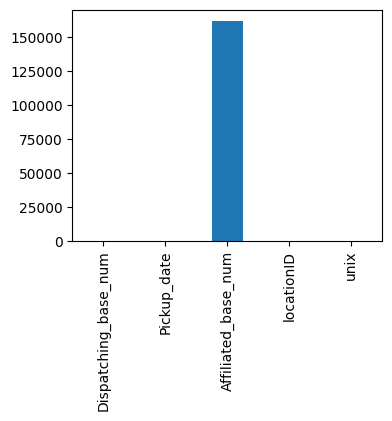

In [10]:
#Plot missing values
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(4,3))
missing_value.plot.bar()

In [11]:
#Remove rows with missing values
df_uber = df_uber.dropna()

In [12]:
missing_value=df_uber.isna().sum()
missing_val = missing_value[missing_value > 0]
for missing_count in missing_val.items():
  print(f"Count of missing values {missing_count}")
else:
  print("Data do not have any missing values")

Data do not have any missing values


<Axes: >

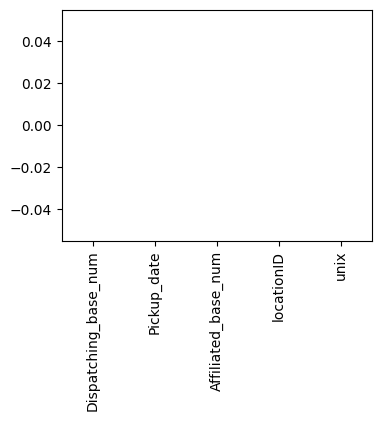

In [13]:
#plot after removing missing values
f, ax = plt.subplots(figsize=(4,3))
missing_value.plot.bar()

In [14]:
#Shape of data after removing missing values
df_uber.shape

(14108284, 5)

In [15]:
#Check duplicate rows in the dataset
duplicate_count=df_uber.duplicated().sum()
print(f"Count of duplicate data {duplicate_count}")

Count of duplicate data 896732


In [16]:
# Remove duplicate rows and check the sum of duplicate rows after removing duplicate rows
df_uber.drop_duplicates(inplace=True)
duplicate_count=df_uber.duplicated().sum()
print(f"Count of duplicate data after removing duplicate rows {duplicate_count}")

Count of duplicate data after removing duplicate rows 0


In [17]:
#Shape of data after removing duplicates
df_uber.shape

(13211552, 5)

## Summary Data Pre-processing
1. Uber data for Jan-June month contain **162195** missing values in Affiliated_base_num column.
2. Data contain **896732** duplicate rows
3. After pre-processing i.e. removing missing values and duplicate data, final dataset consist of **13,211,552** rows

## Perform Exploratory Data Analysis


In [18]:
#Derive month name, name of weekday, hour of the day, month and day numbers from Pickup_date in uber dataset
df_uber["month"] = df_uber["Pickup_date"].dt.month_name()
df_uber["weekday"] = df_uber["Pickup_date"].dt.day_name()
df_uber['hour'] = df_uber['Pickup_date'].dt.hour
df_uber['month_day'] = df_uber['Pickup_date'].apply(lambda pickup: pickup.strftime('%m-%d').split('-'))
df_uber['Monthumn'] = [month_day [0] for month_day in df_uber['month_day']]
df_uber['Day'] = [month_day [1] for month_day in df_uber['month_day']]

In [19]:
df_uber.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09,May,Sunday,9,"[05, 17]",05,17
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09,May,Sunday,9,"[05, 17]",05,17


In [20]:
#Uber pickup count by month
df_uber["month"].value_counts()

June        2571771
May         2483980
February    2141306
April       2112705
March       2062639
January     1839151
Name: month, dtype: int64

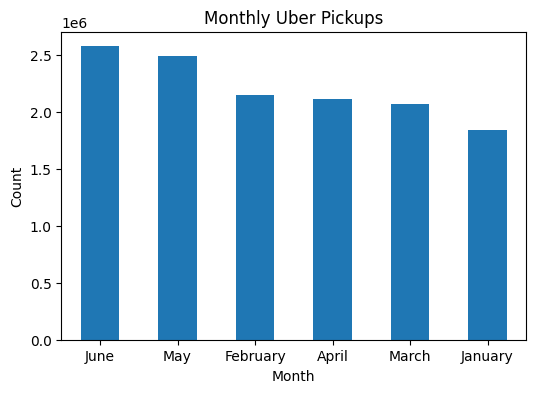

In [21]:
#Plot monthly pickup count
import matplotlib.pyplot as plt

# Plot data
counts = df_uber["month"].value_counts()
plt.figure(figsize=(6, 4))
counts.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly Uber Pickups")
plt.xticks(rotation=0)
plt.show()

## Highest pickups were performed in the month of **June**

In [22]:
#Count of monthly pickups per weekday
monthweek = pd.crosstab(index=df_uber["month"], columns=df_uber["weekday"])
monthweek

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
month,,,,,,,
April,315002,238429,324545,273560,372522,250632,338015
February,360136,264693,354962,284432,323955,276956,276172
January,325261,182785,369693,219884,316857,188802,235869
June,371225,375312,399377,334434,357782,405500,328141
March,309631,269931,314785,313865,277026,320634,256767
May,430134,255501,464298,390391,337607,290004,316045


<Figure size 600x400 with 0 Axes>

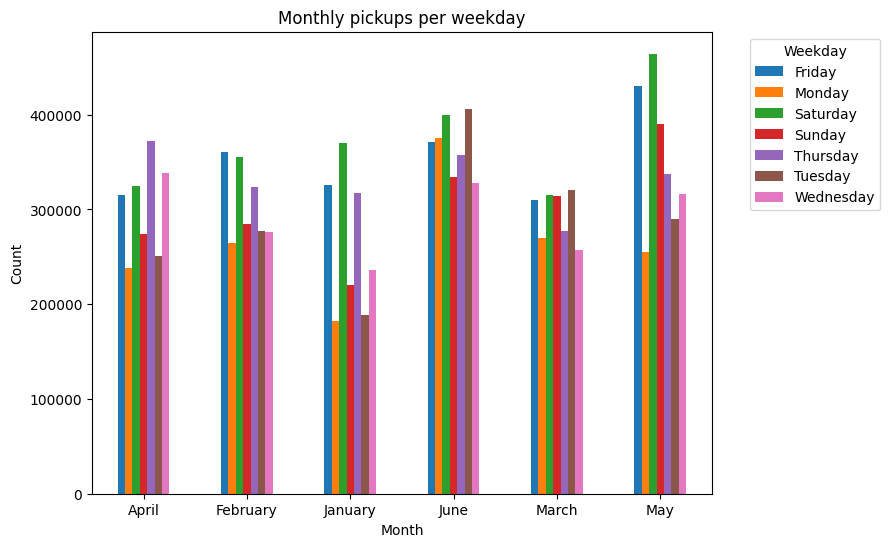

In [23]:
#plot monthly pickups per weekday
plt.figure(figsize=(6, 4))
#monthweek.plot(kind="bar", figsize=(8, 6), cmap='coolwarm')
monthweek.plot(kind="bar", figsize=(8, 6))
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Monthly pickups per weekday")
plt.xticks(rotation=0)

# Show the plot
plt.legend(title="Weekday", bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend
plt.show()

## Summary of Weekday pickup analysis per month
1. Highest number of pickups are performed Saturday in May compared to all other months
2. January, February - Highest pickups are on Saturday
3. March - Hightest pickups are on Tuesday
4. April - Hightest pickups are on Thursday
5. May - Highest pickups are on Saturday
6. June - Hightest pickups are on Tuesday

In [24]:
#Hourly analysis
summary = df_uber.groupby(['weekday', 'hour'], as_index=False).size()
summary.head()

,weekday,hour,size
0,Friday,0,78936
1,Friday,1,44064
2,Friday,2,26942
3,Friday,3,18845
4,Friday,4,22798


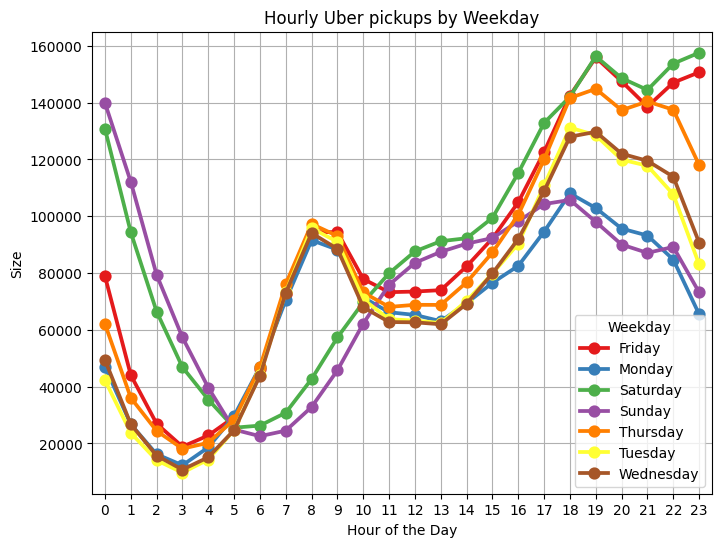

In [25]:
#plot Uber hourly analysis by weekday
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.pointplot(x="hour", y="size", hue="weekday", data=summary, palette="Set1")
plt.xlabel("Hour of the Day")
plt.ylabel("Size")
plt.title("Hourly Uber pickups by Weekday")
plt.legend(title="Weekday")
plt.grid(True)
plt.show()

## Summary of Hourly analysis by weekday
1. Friday and Saturday shows hightest numbers of pickups at 19 and 23 hour
2. Friday and Saturday shows upward trend in pickups after 21 hour vs Other days shows downward trend after 21 hour
3. Both Saturday and Sunday shows same trend between 0-14 hours however from 15 hours trend changes where Saturday has more number of pickups and pickup rise until 23 hours vs Sunday shows downward trend from 18 hour

In [26]:
#Unique location ids in uber data
unique_locid=df_uber['locationID'].unique()
len(unique_locid)

262

In [27]:
#Mark the location ids by traffic contition base on number of pickups performed per location ids
for loc in unique_locid:
  df_temp=df_uber.loc[df_uber['locationID']==loc]
  if (len(df_temp) < 100000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='light'
  elif (len(df_temp)>=100000 and len(df_temp) <=250000 ):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='moderate'
  elif (len(df_temp)>250000):
    df_uber.loc[df_uber['locationID'] == loc, 'Traffic_conditions']='heavy'

print(len(df_uber.loc[df_uber['Traffic_conditions']=='light']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='moderate']))
print(len(df_uber.loc[df_uber['Traffic_conditions']=='heavy']))
df_uber.head()

3284638
6028415
3898499


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions
0,B02617,2015-05-17 09:47:00,B02617,141,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
1,B02617,2015-05-17 09:47:00,B02617,65,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,light
2,B02617,2015-05-17 09:47:00,B02617,100,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
3,B02617,2015-05-17 09:47:00,B02774,80,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate
4,B02617,2015-05-17 09:47:00,B02617,90,1.431856e+09,May,Sunday,9,"[05, 17]",05,17,moderate


In [28]:
df_uber.loc[(df_uber['Traffic_conditions']!='light') & (df_uber['Traffic_conditions']!='moderate') & (df_uber['Traffic_conditions']!='heavy' )]

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions


In [29]:
df_uber.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/uber-raw-data-janjune-15_trafficcond.csv', index = None)

## **Model 1 - Classify the traffic conditions (e.g., light, moderate, heavy) in different zones of NYC using Machine Learning Model**

In [30]:
#Sample dataset to be used for ML model training
random_sample = df_uber.sample(frac=0.01, random_state=42)
random_sample.head()

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,unix,month,weekday,hour,month_day,Monthumn,Day,Traffic_conditions
8799280,B02764,2015-02-04 17:48:48,B02764,219,1.423072e+09,February,Wednesday,17,"[02, 04]",02,04,light
7479949,B02764,2015-04-19 05:34:00,B02764,262,1.429422e+09,April,Sunday,5,"[04, 19]",04,19,moderate
8955397,B02764,2015-06-25 13:05:00,B02670,140,1.435238e+09,June,Thursday,13,"[06, 25]",06,25,moderate
8303321,B02682,2015-05-02 18:17:00,B02682,112,1.430591e+09,May,Saturday,18,"[05, 02]",05,02,moderate
13462605,B02765,2015-06-17 18:51:00,B02765,90,1.434567e+09,June,Wednesday,18,"[06, 17]",06,17,moderate


In [31]:
light_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='light'])
moderate_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='moderate'])
heavy_cond=len(random_sample.loc[random_sample['Traffic_conditions']=='heavy'])
print(f"Sample data contain {light_cond} location ids with light traffic condition")
print(f"Sample data contain {moderate_cond} location ids with moderate traffic condition")
print(f"Sample data contain {heavy_cond} location ids with heavy traffic condition")

Sample data contain 32901 location ids with light traffic condition
Sample data contain 60403 location ids with moderate traffic condition
Sample data contain 38812 location ids with heavy traffic condition


### Pre-processing data for DecisionTreeClassifier Model

In [32]:
# MinMaxscaling and LabelEncoding of data

X = random_sample[['unix','locationID']]
scaler = MinMaxScaler()
X_new = scaler.fit_transform(X)
y = random_sample['Traffic_conditions']
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
X_train, X_test, Y_train, Y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 323)


### Train DecisionTreeClassifier Model

In [33]:
#Apply DecisionTreeClassifier ML model

classifier = DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, Y_train)
#Predicting the Test Set
Y_pred = classifier.predict(X_test)

In [34]:
print("Accuracy is {}".format(accuracy_score(Y_test, Y_pred)))

Accuracy is 0.9955343627005753


### Plot Model Predictions

<Axes: >

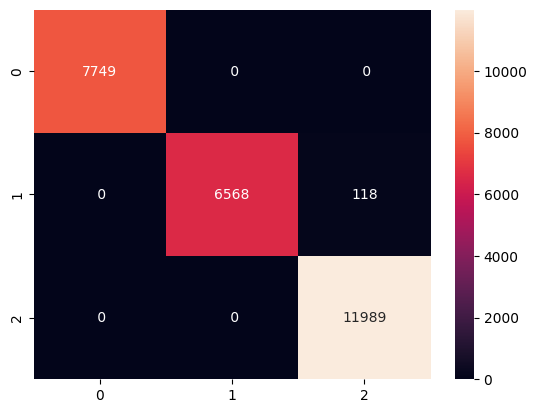

In [35]:
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm,annot=True,fmt='2.0f')

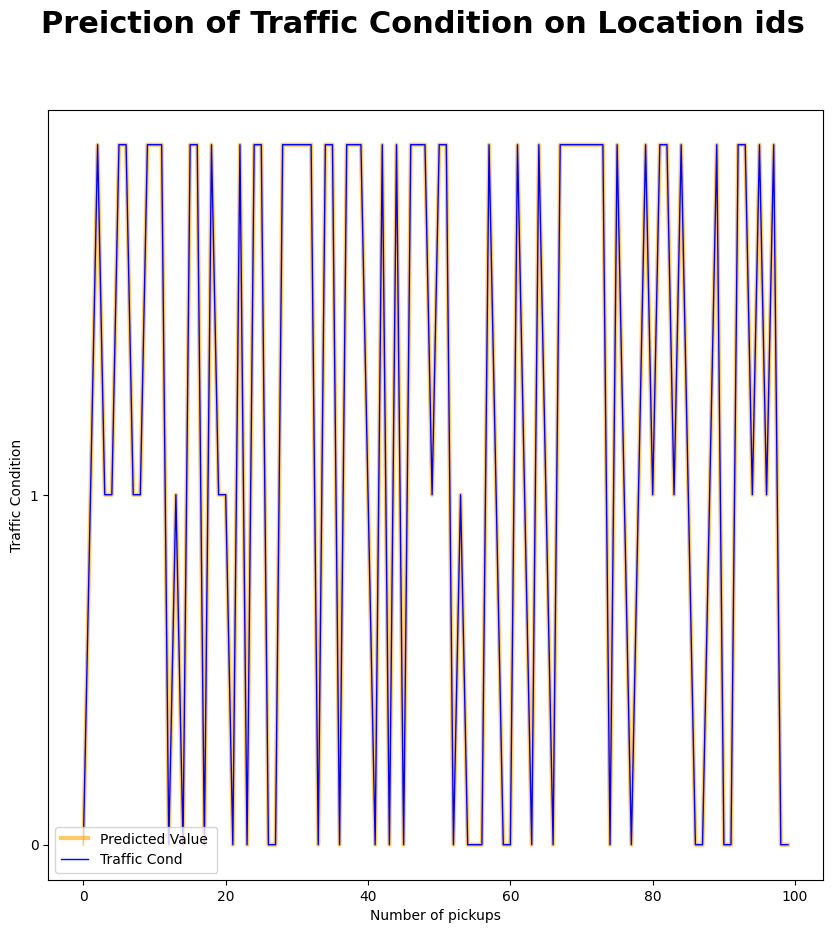

In [36]:
# Show predicted vs actual values for Traffic Condition for first 100 results
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Preiction of Traffic Condition on Location ids', fontsize=22, fontweight='bold')
#ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot( Y_pred[0:100], label='Predicted Value ', linewidth=3, color='orange', alpha=0.6)
ax.plot(Y_test[0:100], label='Traffic Cond',linewidth=1, color='blue')
ax.set( yticks=np.arange(Y_pred.min(), Y_pred.max(), 1), yticklabels=range(0, 2));
ax.set_xlabel('Number of pickups')
ax.set_ylabel('Traffic Condition')
ax.legend()

## DecisionTreeClassifier Result Analysis
- Model is accurately predicting Traffic conditions light, moderate and heavy based on the input features location ids and unix date time
- Model Accuracy is 0.9955343627005753

In [37]:
#Save ML model predictions
df_ml_predict=pd.DataFrame()
df_ml_predict['Traffic_Condition_Actual']=Y_test
df_ml_predict['Traffic_Condition_Predicted']=Y_pred
df_ml_predict.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_ML_Prediction.csv', index = None)

## **Model 2 - Time Series Prediction – Forecast the future demand for Uber pickups across NYC using LSTM**

In [58]:
month_day_group = df_uber.groupby(by = ['Monthumn', 'Day']).size().unstack()
month_day_group

Day,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
Monthumn,,,,,,,,,,,,,,,,,,,,,
01,54369.0,37789.0,56440.0,39362.0,41045.0,50428.0,59771.0,68634.0,67709.0,75676.0,...,63139.0,69251.0,77850.0,55737.0,41921.0,24422.0,58188.0,66429.0,80565.0,88907.0
02,73855.0,66435.0,67531.0,64330.0,77814.0,82677.0,78290.0,60590.0,59971.0,62595.0,...,63870.0,68709.0,76462.0,72202.0,80585.0,85703.0,85069.0,NaN,NaN,NaN
03,65013.0,53372.0,67373.0,65268.0,69742.0,74966.0,74097.0,56893.0,50523.0,64741.0,...,63765.0,56395.0,59494.0,67387.0,71295.0,77449.0,83857.0,69077.0,58436.0,71292.0
04,64412.0,68539.0,71292.0,65223.0,55686.0,51019.0,62838.0,66425.0,71239.0,75417.0,...,74769.0,83122.0,90534.0,96260.0,81836.0,61267.0,64323.0,70306.0,77116.0,NaN
05,85097.0,95693.0,74748.0,61799.0,70715.0,74536.0,79739.0,83794.0,90412.0,74822.0,...,80253.0,73776.0,64869.0,56636.0,68003.0,80519.0,86293.0,89904.0,95821.0,89357.0
06,85030.0,87861.0,79747.0,85836.0,93082.0,93713.0,82361.0,71611.0,76059.0,80039.0,...,70212.0,84311.0,83254.0,90266.0,91319.0,119208.0,85442.0,69605.0,76246.0,NaN


In [59]:
## Aggregate results to form a time-series
month_day_series = [month_day_group.iloc[r,:] for r in range(month_day_group.shape[0])]

In [60]:
month_day_list=[]
for month in month_day_series:
  for days in month:
    month_day_list.append(days)

print(f"Length of MonthDay time-series {len(month_day_list)}")

Length of MonthDay time-series 186


In [61]:
## When month is shorter than 31 days, there will be missing values in series. Removing missing values from series.
nan_indx=np.argwhere(np.isnan(month_day_list) == True)
print(f"number of missing values {len(nan_indx)}")
remove_inds = list(nan_indx.reshape((1,len(nan_indx)))[0])
print(f"ids tha are removed {remove_inds}")
month_day_list_nonan = [month_day_list[i] for i,j in enumerate(month_day_list) if i not in remove_inds]
print(f"Final Length of Monthday list {len(month_day_list_nonan)}")

number of missing values 5
ids tha are removed [59, 60, 61, 123, 185]
Final Length of Monthday list 181


In [62]:
## Convert time-series into data-frame
df_uber_final = pd.DataFrame({'Days': range(1,len(month_day_list_nonan)+1), 'UberPickups': month_day_list_nonan})
df_uber_final.head()

,Days,UberPickups
0,1,54369.0
1,2,37789.0
2,3,56440.0
3,4,39362.0
4,5,41045.0


### Pre-processing data for LSTM
#### Use last 2 weeks(14 days) to predict Uber Trips for current day

In [63]:
#Apply MinMax scalling to transforms data by scaling features to a given range (0,1)

## Split into train-test set:
train_uber_series = df_uber_final.iloc[0:167,1:2].values
test_uber_series = df_uber_final.iloc[167:,1:2].values

print ('Training data: ', train_uber_series.shape)
print ('Testing data: ', test_uber_series.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_uber_series_scaled = mms.fit_transform(train_uber_series)

Training data:  (167, 1)
Testing data:  (14, 1)


In [64]:
x_train = []
y_train = []

for rides in range(14, train_uber_series.shape[0]):
    x_train.append(train_uber_series_scaled[rides-14:rides,0])
    y_train.append(train_uber_series_scaled[rides,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

### Training LSTM Model

In [65]:
np.random.seed(11)
t_start = time.time()

def build_rnn(num_units, input_x, input_y, drpout, epochs, size_of_batch, optimizer, loss):

    lstmmodel = Sequential()

    ## Adding first LSTM layer:
    lstmmodel.add(LSTM(units = num_units, return_sequences = True, input_shape = (input_x.shape[1],1)))
    lstmmodel.add(Dropout(drpout))

    ## Adding second LSTM layer:
    lstmmodel.add(LSTM(units = num_units, return_sequences = True))
    lstmmodel.add(Dropout(drpout))

    ## Adding third LSTM layer:
    lstmmodel.add(LSTM(units = num_units, return_sequences = True))
    lstmmodel.add(Dropout(drpout))

    ## Adding fourth LSTM layer:
    lstmmodel.add(LSTM(units = num_units, return_sequences = True))
    lstmmodel.add(Dropout(drpout))

    ## Adding fifth LSTM layer:
    lstmmodel.add(LSTM(units = num_units, return_sequences = False))
    lstmmodel.add(Dropout(drpout))

    ## Adding o/p layer:
    lstmmodel.add(Dense(units = 1))

    ## Compiling RNN:
    lstmmodel.compile(optimizer = optimizer, loss = loss)

    ## Fitting RNN to training set:
    lstmmodel.fit(x = input_x, y = input_y, epochs = epochs, batch_size = size_of_batch)

    return lstmmodel

lstmmodel = build_rnn(num_units = 40, input_x = x_train, input_y = y_train, drpout = 0.2, epochs = 1000, size_of_batch = 16, optimizer = 'adam', loss = 'mean_squared_error')

print (time.time() - t_start)

Epoch 1/1000
10/10 [==============================] - 10s 42ms/step - loss: 0.2507
Epoch 2/1000
10/10 [==============================] - 0s 26ms/step - loss: 0.0401
Epoch 3/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0298
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0313
Epoch 5/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0253
Epoch 6/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0218
Epoch 7/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0240
Epoch 8/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0225
Epoch 9/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0236
Epoch 10/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0228
Epoch 11/1000
10/10 [==============================] - 0s 28ms/step - loss: 0.0224
Epoch 12/1000
10/10 [==============================] - 0s 27ms/step - loss: 0.0279
Epoch 13/100

In [66]:
# using last 14 values to predict the next value
test_uber_series_updated = df_uber_final[len(df_uber_final) - len(test_uber_series) - 14:]['UberPickups'].values
test_uber_series_updated = test_uber_series_updated.reshape(-1,1)
test_uber_series_updated = mms.transform(test_uber_series_updated)
test_uber_series_updated[0:10]

array([[0.65726947],
       [0.72960772],
       [0.81569131],
       [0.82318768],
       [0.68832419],
       [0.56061254],
       [0.61345546],
       [0.66073847],
       [0.79777604],
       [0.82472022]])

In [67]:
## Create properly structured test set:
x_test = []
for rides in range(14,29):
    x_test.append(test_uber_series_updated[rides-14:rides,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(15, 14, 1)

In [69]:
## Make prediction for test set and bring values back to original scale
pred = lstmmodel.predict(x_test)
pred = mms.inverse_transform(pred)

## Check RMSE on test-set
residuals = pred[0:-1] - test_uber_series
rmse = np.sqrt(np.mean(residuals**2))
rmse

1/1 [==============================] - 0s 25ms/step


10500.092802815036

### Plot LSTM Predictions

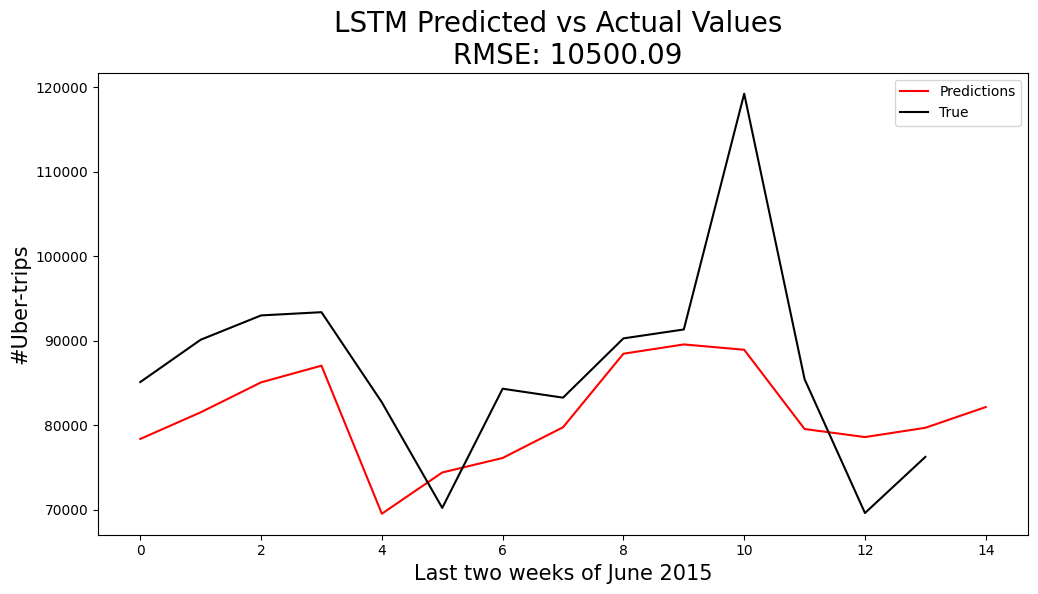

In [72]:
fig, ax = plt.subplots(figsize = (12,6))

e = [i*0.05 for i in pred]
ax.plot(pred, color = 'red', label = 'Predictions')
#ax.errorbar(x = range(15), y = pred, yerr = e, fmt = '*', color = 'r')
ax.plot(test_uber_series, color = 'black', label = 'True')

ax.set_xlabel('Last two weeks of June 2015', fontsize = 15)
ax.set_ylabel('#Uber-trips', fontsize = 15)
ax.set_title('LSTM Predicted vs Actual Values \n RMSE: {}'.format(np.round(rmse,2)), fontsize = 20)

ax.legend()
plt.show()

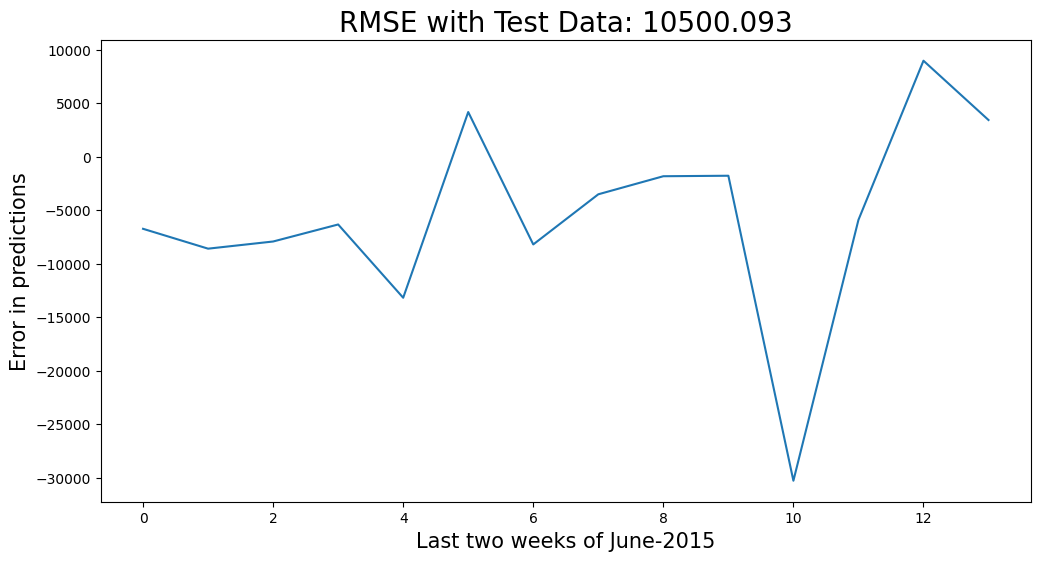

In [75]:
fig ,ax = plt.subplots(figsize = (12,6))
ax.plot(residuals)

ax.set_xlabel('Last two weeks of June-2015', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('RMSE with Test Data: {}'.format(round(rmse, 3)), fontsize = 20)
plt.show()

5/5 [==============================] - 0s 12ms/step


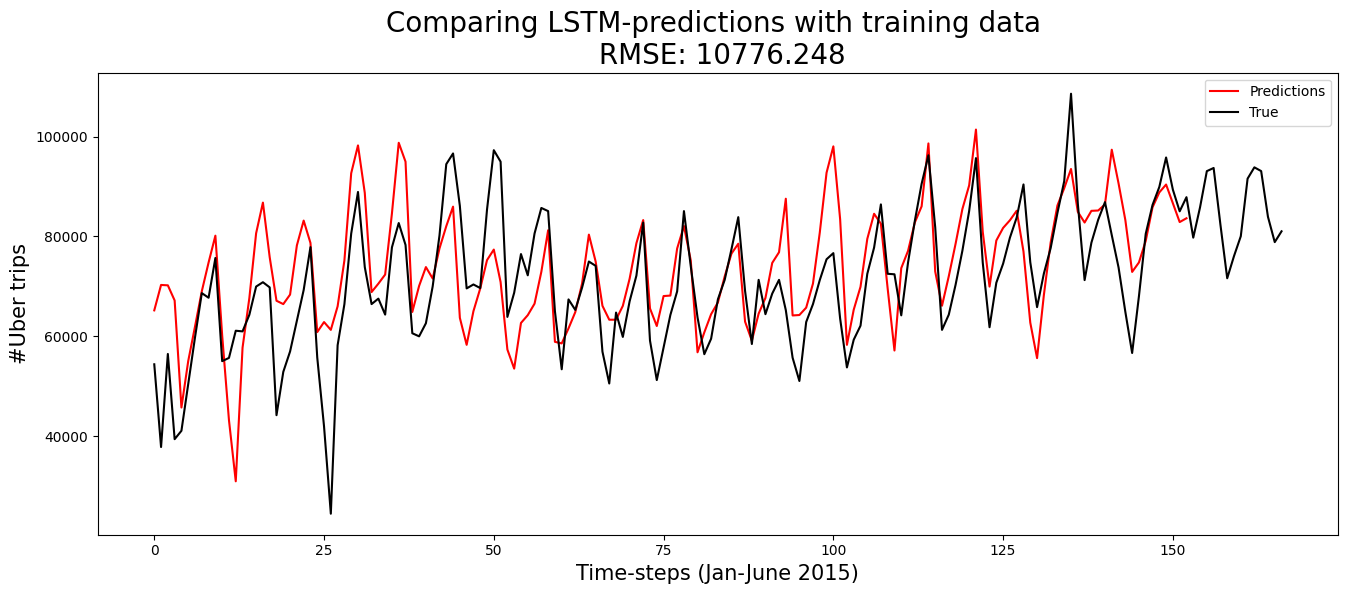

In [76]:
pred_train = lstmmodel.predict(x_train)
pred_train = mms.inverse_transform(pred_train)
residuals_train = pred_train - train_uber_series[0:-14]
rmse_train = np.sqrt(np.mean(residuals_train**2))

fig, ax = plt.subplots(figsize = (16,6))

ax.plot(pred_train, color = 'red', label = 'Predictions')
ax.plot(train_uber_series, color = 'black', label = 'True')

ax.set_xlabel('Time-steps (Jan-June 2015)', fontsize = 15)
ax.set_ylabel('#Uber trips', fontsize = 15)
ax.set_title('Comparing LSTM-predictions with training data \n RMSE: {}'.format(round(rmse_train,3)), fontsize = 20)

ax.legend()
plt.show()

In [77]:
#Export prediction results for LSTM
df_pred=pd.DataFrame()
df_pred['Actual_trips']=train_uber_series[0:-14].flatten()
df_pred['Predicted_trips']=pred_train

In [78]:
df_pred.to_csv('/content/drive/My Drive/ColabNotebooks/IOT/Final Project/Final_Project_LSTM_Prediction.csv', index = None)

## LSTM Prediction Analysis
- From the graph LSTM predicted VS True Value we can observe that the predicted values of number of uber trips followed the actual values of uber trips until 9th day.
- On 10th day actual trip values reached 120,000 which is higher compared to last 9 days where the trip values lies between 70,000 to 95,000 range.
- Predicted vaules on 10th day did not follow actual values of trips as the actual values are higher in number and could be outliers or anomalies.
- This proves that model is performing well and did not overfit with testing data.
- RMSE value(Test Data) 10,500.93 indicates the average deviation between the predicted values generated by the LSTM model and the actual values in the training data
- We can see from RMSE with Test Data graph that the peak deviation occured on 10th day with 30,000 trips, rest of the days deviation lies in range of 5000 to -10,000